# Part I - Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

# Import Technical Analysis library to have access to technical indicators
import pandas_ta as ta

# Import Cryptocurrency library that enables to extract price and volume data
import ccxt

In [2]:
# Start with instantiation
binance = ccxt.binance ()

# Force HTTP reload = True. If not reloaded, then it shows cached version
reloadedMarkets = binance.load_markets(True)

In [3]:
# Load price and volume of BTC with 4h timeframes since 01-01-2022
BTC_data = []
since = binance.parse8601('2022-01-01T00:00:00Z')

while since < binance.milliseconds():
    symbol = 'BTC/USDT'
    timeframe='4h'
    price_batch = binance.fetchOHLCV(symbol, timeframe, since, params = {})
    if price_batch:
        BTC_data += price_batch
        since = max(price_batch)[0] + 1
    else:
        break
BTC_data = pd.DataFrame(BTC_data)   

# Load price and volume of ETH with 4h timeframes since 01-01-2022
ETH_data = []
since = binance.parse8601('2022-01-01T00:00:00Z')

while since < binance.milliseconds():
    symbol = 'ETH/USDT'
    timeframe='4h'
    price_batch = binance.fetchOHLCV(symbol, timeframe, since, params = {})
    if price_batch:
        ETH_data += price_batch
        since = max(price_batch)[0] + 1
    else:
        break
ETH_data = pd.DataFrame(ETH_data)   

In [4]:
# Convert timestamp format to human-readable 
data_list = [BTC_data, ETH_data]

for i in range(len(data_list)):
    for j in range(len(data_list[i])):
            timestamp_temp = list(data_list[i].iloc[j:j+1][0])[0]
            timestamp = timestamp_temp/1000
            date = datetime.fromtimestamp(timestamp)
            data_list[i].at[j, 0] = date
            j = j + 1 

In [5]:
# Name the columns
for k in range(len(data_list)):
    data_list[k]['TIME'] = data_list[k][0]
    data_list[k]['OPEN'] = data_list[k][1]
    data_list[k]['HIGH'] = data_list[k][2]
    data_list[k]['LOW'] = data_list[k][3]
    data_list[k]['CLOSE'] = data_list[k][4]
    data_list[k]['VOLUME'] = data_list[k][5]
    data_list[k].drop(columns = [0,1,2,3,4,5], axis=1, inplace=True)

# Part II - Generate Trading Signals

In [16]:
# Disable the chain assignment warning
pd.options.mode.chained_assignment = None

# Create a data dictionary that contains both BTC_data and ETH_data by looping over to avoid inefficiency 
dataset = {'BTC_data': BTC_data,'ETH_data': ETH_data}

# Specify the lookback period
RSI_period = 14

for i in list(dataset.keys()):
    
    # Add RSI with 14 periods lookback column
    dataset[i]['RSI_14'] = ta.rsi(dataset[i].CLOSE, length = RSI_period)
    
    # Add RSI buy and sell signal columns with default value 0 (no signal) 
    dataset[i]['RSI_14_Sell_Signal'] = 0
    dataset[i]['RSI_14_Buy_Signal'] = 0
    
    #Set threshold for sell signal - You can modify it
    dataset[i]['RSI_Sell_Threshold'] = 70
    #Set threshold for buy signal - You can modify it
    dataset[i]['RSI_Buy_Threshold'] = 30
    
    #Create signal for BUY                                                                   
    dataset[i]['RSI_14_Buy_Signal'][RSI_period:] = np.where(dataset[i]['RSI_14'][RSI_period:] <= 
                                                   dataset[i]['RSI_Buy_Threshold'][RSI_period:], 1,0) 
    
    #Create signal for SELL
    dataset[i]['RSI_14_Sell_Signal'][RSI_period:] = np.where(dataset[i]['RSI_14'][RSI_period:] >= 
                                                   dataset[i]['RSI_Sell_Threshold'][RSI_period:], -1 , 0)    

# Count number of records in the dataset
Number_of_Records_BTC = dataset['BTC_data']['TIME'].count()
Number_of_Records_ETH = dataset['ETH_data']['TIME'].count()

# Filter buy/sell signals from RSI
RSI_Signal_Count_BTC = dataset['BTC_data'][(dataset['BTC_data']['RSI_14_Buy_Signal'] == 1) | (dataset['BTC_data']['RSI_14_Sell_Signal'] == -1)]['TIME'].count()
RSI_Signal_Count_ETH = dataset['ETH_data'][(dataset['ETH_data']['RSI_14_Buy_Signal'] == 1) | (dataset['ETH_data']['RSI_14_Sell_Signal'] == -1)]['TIME'].count()

# Calculate the frequency of signals with RSI (Remember that each record logged in 4h interval. Thus, the result should be multiplied by 4)

RSI_Signal_Freq_BTC = np.round((Number_of_Records_BTC / RSI_Signal_Count_BTC) * 4, 1) 
RSI_Signal_Freq_ETH = np.round((Number_of_Records_ETH / RSI_Signal_Count_ETH) * 4, 1)  

# Print number of signals and corresponding frequency
print(f'RSI Signal Count for BTC: {RSI_Signal_Count_BTC}')
print(f'RSI Signal Count for ETH: {RSI_Signal_Count_ETH}')
print(' ')
print(f'RSI Signal Frequency for BTC (in hours): {RSI_Signal_Freq_BTC}')
print(f'RSI Signal Frequency for ETH (in hours): {RSI_Signal_Freq_ETH}')

RSI Signal Count for BTC: 170
RSI Signal Count for ETH: 182
 
RSI Signal Frequency for BTC (in hours): 32.9
RSI Signal Frequency for ETH (in hours): 30.7


In [17]:
# Specify the lookback period
BB_period = 20 

for i in list(dataset.keys()):
    
    # Create Dataframe with Bollinger Bands (BBL_20 is the lower band, BBU_20 is the upper band BBM_20 is the middle of BBL_20 and BBU_20) 
    BB_dataset = ta.bbands(dataset[i].CLOSE, length = BB_period)
    
    # Concatenate BB_dataset with BTC_data and ETH_data
    dataset[i] = pd.concat([dataset[i], BB_dataset], axis=1)
    
    # Add BB overbought and oversold signal columns with default value 0 (no signal) 
    dataset[i]['BB_20_Sell_Signal'] = 0
    dataset[i]['BB_20_Buy_Signal'] = 0
    
    #Create signal for BUY                                                                   
    dataset[i]['BB_20_Buy_Signal'][BB_period:] = np.where(dataset[i]['CLOSE'][BB_period:] <= 
                                                   dataset[i]['BBL_20'][BB_period:], 1,0) 
    
    #Create signal for SELL
    dataset[i]['BB_20_Sell_Signal'][BB_period:] = np.where(dataset[i]['CLOSE'][BB_period:] >= 
                                                   dataset[i]['BBU_20'][BB_period:], -1 , 0)
    
# Count number of records in the dataset
Number_of_Records_BTC = dataset['BTC_data']['TIME'].count()
Number_of_Records_ETH = dataset['ETH_data']['TIME'].count()

# Filter buy/sell signals for BB
BB_Signal_Count_BTC = dataset['BTC_data'][(dataset['BTC_data']['BB_20_Buy_Signal'] == 1) | (dataset['BTC_data']['BB_20_Sell_Signal'] == -1)]['TIME'].count()
BB_Signal_Count_ETH = dataset['ETH_data'][(dataset['ETH_data']['BB_20_Buy_Signal'] == 1) | (dataset['ETH_data']['BB_20_Sell_Signal'] == -1)]['TIME'].count()

# Calculate the frequency of signals with BB (Remember that each record logged in 4h interval. Thus, the result should be multiplied by 4)
BB_Signal_Freq_BTC = np.round((Number_of_Records_BTC / BB_Signal_Count_BTC) * 4, 1) 
BB_Signal_Freq_ETH = np.round((Number_of_Records_ETH / BB_Signal_Count_ETH) * 4, 1)  

# Print number of signals and corresponding frequency
print(f'BB Signal Count for BTC: {BB_Signal_Count_BTC}')
print(f'BB Signal Count for ETH: {BB_Signal_Count_ETH}')
print(' ')
print(f'BB Signal Frequency for BTC (in hours): {BB_Signal_Freq_BTC}')
print(f'BB Signal Frequency for ETH (in hours): {BB_Signal_Freq_ETH}')    

BB Signal Count for BTC: 167
BB Signal Count for ETH: 173
 
BB Signal Frequency for BTC (in hours): 33.5
BB Signal Frequency for ETH (in hours): 32.3


In [18]:
# Specify the lookback period
MFI_period = 20

for i in list(dataset.keys()):
    
    # Add MFI with 20 periods lookback column
    dataset[i]['MFI_20'] = ta.mfi(high = dataset[i].HIGH, low = dataset[i].LOW, close = dataset[i].CLOSE, volume = dataset[i].VOLUME, length = MFI_period)
    
    # Add MFI overbought and oversold signal columns with default value 0 (no signal) 
    dataset[i]['MFI_20_Sell_Signal'] = 0
    dataset[i]['MFI_20_Buy_Signal'] = 0
    
    #Set threshold for sell signal - You can modify it
    dataset[i]['MFI_Sell_Threshold'] = 70
    #Set threshold for buy signal - You can modify it
    dataset[i]['MFI_Buy_Threshold'] = 30
    
    #Create signal for BUY                                                                   
    dataset[i]['MFI_20_Buy_Signal'][MFI_period:] = np.where(dataset[i]['MFI_20'][MFI_period:] <= 
                                                   dataset[i]['MFI_Buy_Threshold'][MFI_period:], 1,0) 
    
    #Create signal for SELL
    dataset[i]['MFI_20_Sell_Signal'][MFI_period:] = np.where(dataset[i]['MFI_20'][MFI_period:] >= 
                                                   dataset[i]['MFI_Sell_Threshold'][MFI_period:], -1 , 0)    

# Filter buy/sell signals for MFI
MFI_Signal_Count_BTC = dataset['BTC_data'][(dataset['BTC_data']['MFI_20_Buy_Signal'] == 1) | (dataset['BTC_data']['MFI_20_Sell_Signal'] == -1)]['TIME'].count()
MFI_Signal_Count_ETH = dataset['ETH_data'][(dataset['ETH_data']['MFI_20_Buy_Signal'] == 1) | (dataset['ETH_data']['MFI_20_Sell_Signal'] == -1)]['TIME'].count()

# Calculate the frequency of signals with MFI (Remember that each record logged in 4h interval. Thus, the result should be multiplied by 4)
MFI_Signal_Freq_BTC = np.round((Number_of_Records_BTC / MFI_Signal_Count_BTC) * 4, 1) 
MFI_Signal_Freq_ETH = np.round((Number_of_Records_ETH / MFI_Signal_Count_ETH) * 4, 1)  

# Print number of signals and corresponding frequency
print(f'MFI Signal Count BTC: {MFI_Signal_Count_BTC}')
print(f'MFI Signal Count ETH: {MFI_Signal_Count_ETH}')
print(' ')
print(f'MFI Signal Frequency BTC in hours: {MFI_Signal_Freq_BTC}')
print(f'MFI Signal Frequency ETH in hours: {MFI_Signal_Freq_ETH}')    

MFI Signal Count BTC: 312
MFI Signal Count ETH: 328
 
MFI Signal Frequency BTC in hours: 17.9
MFI Signal Frequency ETH in hours: 17.0


In [19]:
# Filter Buy/Sell Signals by using RSI, BB and MFI combined
Signals_BTC = dataset['BTC_data'][((dataset['BTC_data']['MFI_20_Buy_Signal'] == 1) & (dataset['BTC_data']['BB_20_Buy_Signal'] == 1) & (dataset['BTC_data']['RSI_14_Buy_Signal'] == 1))
                                 |((dataset['BTC_data']['MFI_20_Sell_Signal'] == -1) & (dataset['BTC_data']['BB_20_Sell_Signal'] == -1) & (dataset['BTC_data']['RSI_14_Sell_Signal'] == -1))]

Signals_ETH = dataset['ETH_data'][((dataset['ETH_data']['MFI_20_Buy_Signal'] == 1) & (dataset['ETH_data']['BB_20_Buy_Signal'] == 1) & (dataset['ETH_data']['RSI_14_Buy_Signal'] == 1))
                                 |((dataset['ETH_data']['MFI_20_Sell_Signal'] == -1) & (dataset['ETH_data']['BB_20_Sell_Signal'] == -1) & (dataset['ETH_data']['RSI_14_Sell_Signal'] == -1))]

# Merge trading signal of indicators in one column for simplicity (without buy/sell specification) 
# Note that because all indicators show the same direction after filtering, one indicator can be used for reference
Signals_BTC['Trade_Signal_Raw'] = Signals_BTC['RSI_14_Buy_Signal'] 
Signals_ETH['Trade_Signal_Raw'] = Signals_ETH['RSI_14_Buy_Signal']                                             

# Generate trading positions 
Signals_BTC['Trade_Position'] = Signals_BTC['Trade_Signal_Raw'].diff()
Signals_ETH['Trade_Position'] = Signals_ETH['Trade_Signal_Raw'].diff()

# Fix the first signal's Trade_Signal value due to diff() function outputing NaN since it's the first signal  
Signals_BTC['Trade_Position'].iloc[0] = Signals_BTC['Trade_Signal_Raw'].iloc[0]
Signals_ETH['Trade_Position'].iloc[0] = Signals_ETH['Trade_Signal_Raw'].iloc[0]

# Due to restricting Pyramiding in our Trading Strategy, we filter buy and sell positions in a row 
Signals_BTC = Signals_BTC[Signals_BTC['Trade_Position'].isin([1.0, -1.0])]
Signals_ETH = Signals_ETH[Signals_ETH['Trade_Position'].isin([1.0, -1.0])]


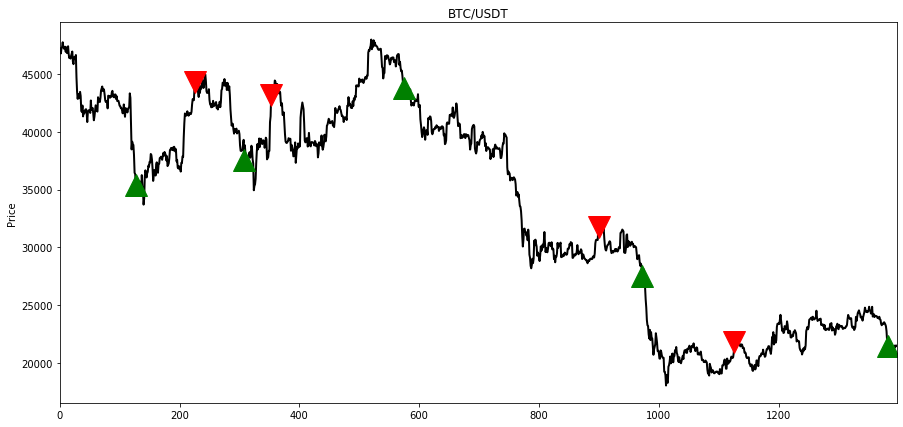

In [29]:
# Plot positions for BTC (Green triangles are long and red triangles are short)
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(111, title = 'BTC/USDT', ylabel = 'Price')

dataset['BTC_data']['CLOSE'].plot(ax = ax1, color='black', lw=2.)

ax1.plot(Signals_BTC.loc[Signals_BTC.Trade_Position == 1].index,
        Signals_BTC.CLOSE[Signals_BTC.Trade_Position == 1], '^', markersize=22, color='g')

ax1.plot(Signals_BTC.loc[Signals_BTC.Trade_Position == -1].index,
        Signals_BTC.CLOSE[Signals_BTC.Trade_Position == -1], 'v', markersize=22, color='r')

plt.show(fig)

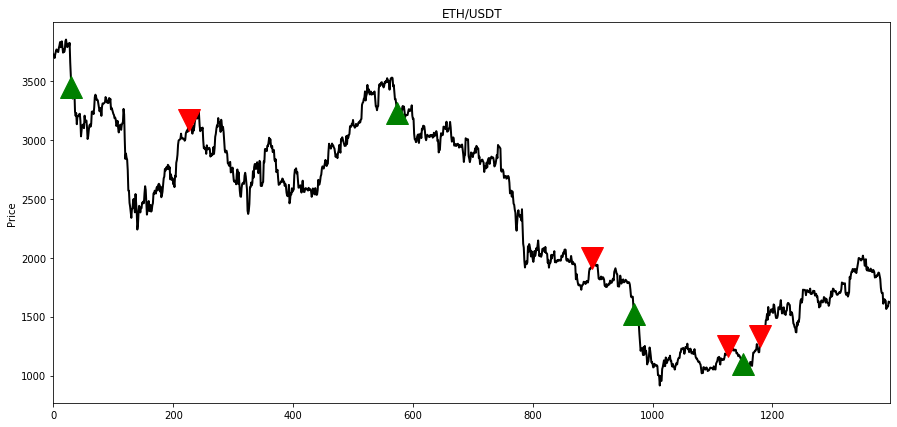

In [30]:
# Plot positions for ETH (Green triangles are long and red triangles are short)
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(111, title = 'ETH/USDT', ylabel = 'Price')

dataset['ETH_data']['CLOSE'].plot(ax = ax1, color='black', lw=2.)

ax1.plot(Signals_ETH.loc[Signals_ETH.Trade_Position == 1].index,
        Signals_ETH.CLOSE[Signals_ETH.Trade_Position == 1], '^', markersize=22, color='g')

ax1.plot(Signals_ETH.loc[Signals_ETH.Trade_Position == -1].index,
        Signals_ETH.CLOSE[Signals_ETH.Trade_Position == -1], 'v', markersize=22, color='r')

plt.show(fig)

# Part III - Backtest

In [37]:
# Let's assume we have 100,000 USD as initial capital and at every signal we buy/sell one BTC
initial_capital = float(100000)

# Create an empty positions DataFrame with the same index as Signals_BTC to use as intermediary step
positions_BTC = pd.DataFrame(index = Signals_BTC.index)

# Update the name 'Trade_Position' to 'Position'
positions_BTC['Current_Position'] = Signals_BTC['Trade_Position']

# Create the portfolio DataFrame to track the changes in portfolio 
portfolio_BTC = positions_BTC.multiply(Signals_BTC['CLOSE'], axis=0)

# Place the Next_Position on the same row with Current_Position for computational easiness
portfolio_BTC['Next_Position'] = portfolio_BTC['Current_Position'].shift(-1)

# Drop the last position because we do not know what the return of that position will be. That's why, it is irrelevant in the Backtest
portfolio_BTC.drop(index=portfolio_BTC.index[-1], axis=0, inplace=True)

# Because there are both long and short positions which result in positive and negative values, we use abs() function to get the size of position
portfolio_BTC['Current_Position_Size'] = portfolio_BTC['Current_Position'].abs()
portfolio_BTC['Next_Position_Size'] = portfolio_BTC['Next_Position'].abs()

# Calculate Gain/Loss for positions by checking whether they are long or short
portfolio_BTC['Gain/Loss'] = np.where(portfolio_BTC['Current_Position'] > 0, portfolio_BTC['Next_Position_Size'] - portfolio_BTC['Current_Position_Size'], portfolio_BTC['Current_Position_Size'] - portfolio_BTC['Next_Position_Size'])

# Calculate Cumulative Position Size to calculate the Cumulative Percentage Return
portfolio_BTC['Cumulative_Position_Size'] = portfolio_BTC['Current_Position_Size'].cumsum()

# Calculate Cumulative Gain/Loss from Gain/Loss
portfolio_BTC['Cumulative_Gain/Loss'] = portfolio_BTC['Gain/Loss'].cumsum()

# Calculate Total Holdings by summing the initial capital (100,000) and Cumulative Gain/Loss
portfolio_BTC['Total_Holdings'] = initial_capital + portfolio_BTC['Cumulative_Gain/Loss']

# Calculate Percentage Return per position 
portfolio_BTC['%_Return_per_Position'] = 100 * portfolio_BTC['Gain/Loss'] / portfolio_BTC['Current_Position_Size']

# Calculate Cumulative Percentage Return  
portfolio_BTC['%_Return_Cumulative'] = 100 * portfolio_BTC['Cumulative_Gain/Loss'] / portfolio_BTC['Cumulative_Position_Size']


In [38]:
# Cumulative Return of the Trading Stragey
cumulative_return_BTC = round(portfolio_BTC.iloc[-1]['%_Return_Cumulative'],2)

# Number of profitable/unprofitable positions
total_closed_positions_BTC = portfolio_BTC['Current_Position'].count()
profitable_positions_BTC = portfolio_BTC[portfolio_BTC['%_Return_per_Position'] > 0]['%_Return_per_Position'].count()
unprofitable_positions_BTC = portfolio_BTC[portfolio_BTC['%_Return_per_Position'] < 0]['%_Return_per_Position'].count()

# Number of profitable positions divided by number of unprofitable positions
win_ratio_BTC = round(profitable_positions_BTC/unprofitable_positions_BTC,2)

# Number of profitable positions divided by total closed positions
percent_profitable_BTC = 100 * round(profitable_positions_BTC/total_closed_positions_BTC,2)

# Maximum Drawdown
maximum_drawdown_BTC = round(portfolio_BTC['%_Return_Cumulative'].min(),2)

print(f'Cumulative return of the Trading Stragey: {cumulative_return_BTC}%')
print(f'Total number of closed positions: {total_closed_positions_BTC}')
print(f'Number of profitable positions: {profitable_positions_BTC}')
print(f'Number of unprofitable positions: {unprofitable_positions_BTC}')
print(f'Profitability in terms of number of positions: {percent_profitable_BTC}%')
print(f'Win Ratio: {win_ratio_BTC}')
print(f'Maximum Drawdown {maximum_drawdown_BTC}%')

Cumulative return of the Trading Stragey: 2.58%
Total number of closed positions: 8
Number of profitable positions: 5
Number of unprofitable positions: 3
Profitability in terms of number of positions: 62.0%
Win Ratio: 1.67
Maximum Drawdown 2.58%


In [39]:
# Let's assume we have 100,000 USD as initial capital and at every signal we buy/sell one ETH
initial_capital = float(100000)

# Create an empty positions DataFrame with the same index as Signals_ETH to use as intermediary step
positions_ETH = pd.DataFrame(index = Signals_ETH.index)

# Update the name 'Trade_Position' to 'Position'
positions_ETH['Current_Position'] = Signals_ETH['Trade_Position']

# Create the portfolio DataFrame to track the changes in portfolio 
portfolio_ETH = positions_ETH.multiply(Signals_ETH['CLOSE'], axis=0)

# Place the Next_Position on the same row with Current_Position for computational easiness
portfolio_ETH['Next_Position'] = portfolio_ETH['Current_Position'].shift(-1)

# Drop the last position because we do not know what the return of that position will be. That's why, it is irrelevant in the Backtest
portfolio_ETH.drop(index=portfolio_ETH.index[-1], axis=0, inplace=True)

# Because there are both long and short positions which result in positive and negative values, we use abs() function to get the size of position
portfolio_ETH['Current_Position_Size'] = portfolio_ETH['Current_Position'].abs()
portfolio_ETH['Next_Position_Size'] = portfolio_ETH['Next_Position'].abs()

# Calculate Gain/Loss for positions by checking whether they are long or short
portfolio_ETH['Gain/Loss'] = np.where(portfolio_ETH['Current_Position'] > 0, portfolio_ETH['Next_Position_Size'] - portfolio_ETH['Current_Position_Size'], portfolio_ETH['Current_Position_Size'] - portfolio_ETH['Next_Position_Size'])

# Calculate Cumulative Position Size to calculate the Cumulative Percentage Return
portfolio_ETH['Cumulative_Position_Size'] = portfolio_ETH['Current_Position_Size'].cumsum()

# Calculate Cumulative Gain/Loss from Gain/Loss
portfolio_ETH['Cumulative_Gain/Loss'] = portfolio_ETH['Gain/Loss'].cumsum()

# Calculate Total Holdings by summing the initial capital (100,000) and Cumulative Gain/Loss
portfolio_ETH['Total_Holdings'] = initial_capital + portfolio_ETH['Cumulative_Gain/Loss']

# Calculate Percentage Return per position 
portfolio_ETH['%_Return_per_Position'] = 100 * portfolio_ETH['Gain/Loss'] / portfolio_ETH['Current_Position_Size']

# Calculate Cumulative Percentage Return  
portfolio_ETH['%_Return_Cumulative'] = 100 * portfolio_ETH['Cumulative_Gain/Loss'] / portfolio_ETH['Cumulative_Position_Size']


In [40]:
# Cumulative Return of the Trading Stragey
cumulative_return_ETH = round(portfolio_ETH.iloc[-1]['%_Return_Cumulative'],2)

# Number of profitable/unprofitable positions
total_closed_positions_ETH = portfolio_ETH['Current_Position'].count()
profitable_positions_ETH = portfolio_ETH[portfolio_ETH['%_Return_per_Position'] > 0]['%_Return_per_Position'].count()
unprofitable_positions_ETH = portfolio_ETH[portfolio_ETH['%_Return_per_Position'] < 0]['%_Return_per_Position'].count()

# Number of profitable positions divided by number of unprofitable positions
win_ratio_ETH = round(profitable_positions_ETH/unprofitable_positions_ETH,2)

# Number of profitable positions divided by total closed positions
percent_profitable_ETH = 100 * round(profitable_positions_ETH/total_closed_positions_ETH,2)

# Maximum Drawdown
maximum_drawdown_ETH = round(portfolio_ETH['%_Return_Cumulative'].min(),2)

print(f'Cumulative return of the Trading Stragey: {cumulative_return_ETH}%')
print(f'Total number of closed positions: {total_closed_positions_ETH}')
print(f'Number of profitable positions: {profitable_positions_ETH}')
print(f'Number of unprofitable positions: {unprofitable_positions_ETH}')
print(f'Profitability in terms of number of positions: {percent_profitable_ETH}%')
print(f'Win Ratio: {win_ratio_ETH}')
print(f'Maximum Drawdown {maximum_drawdown_ETH}%')

Cumulative return of the Trading Stragey: -6.14%
Total number of closed positions: 7
Number of profitable positions: 3
Number of unprofitable positions: 4
Profitability in terms of number of positions: 43.0%
Win Ratio: 0.75
Maximum Drawdown -15.93%
